<a href="https://colab.research.google.com/github/zelal-Eizaldeen/project2_Walmart_Price_Prediction/blob/main/Assignment_4_3113_zelalae2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Team Members**

Zilal Eiz Aldin (Online MCS) Zelalae2@illinois.edu

Mesay Taye (Online MCS) mesayst2@illinois.edu

Jianci Zhai (Online MCS) jianciz2@illinois.edu

# **Contribution of each member**

XXX By Mesay

XXX By Zilal

XXX By Jianci

# **Reference**
https://campuswire.com/c/GB46E5679/feed/587

https://liangfgithub.github.io/Coding/F24_Coding4.pdf

# **Setting**

In [1]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:

# import all libraries
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import scale
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_squared_error,make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

from scipy.stats import multivariate_normal

from matplotlib.colors import LogNorm

from sklearn.model_selection import GridSearchCV
from sklearn.mixture import GaussianMixture

# **Part I: Gaussian Mixtures**

reference:

https://liangfgithub.github.io/PSL/w7/w7_3_EM.html

https://campuswire.com/c/GB46E5679/feed/589 (hint)


In [3]:
#change with your path
path_to_data='/content/drive/MyDrive/MastersDegree/CS598 PSL/Assignments/CA/'

Text(0, 0.5, 'Duration')

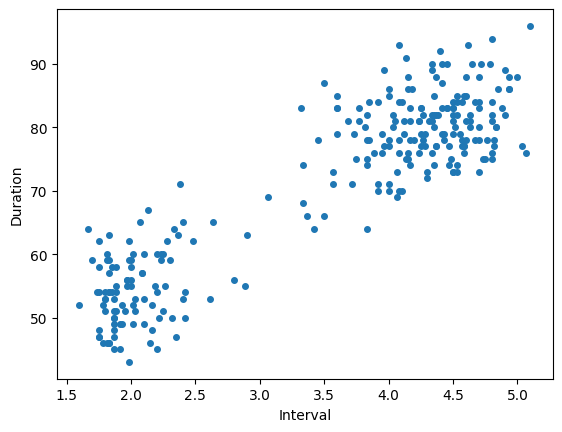

In [4]:
data = pd.read_table(path_to_data+"faithful.dat", sep="\s+", index_col=0)
plt.scatter(data['eruptions'], data['waiting'], 16)
plt.xlabel('Interval')
plt.ylabel('Duration')

In [5]:
data.head()

,eruptions,waiting
1,3.600,79
2,1.800,54
3,3.333,74
4,2.283,62
5,4.533,85


In [230]:
#create a matrix for all sample sizes for G, the corresponding p, u
def create_s_mtrx(G,n,s_interval=10): #sample size interval is default to 10, not required by instruction, but will need to handle G >2 as required by the instruction
  #matrix of G/ aka Z
  G_mtrx = np.arange(1,G+1,1)
  #sample size by group
  s_mtrx = s_interval*2**(G_mtrx-1)

  cumsum_s_mtrx =  np.cumsum(s_mtrx, axis =0)
  cumsum_s_mtrx

  #anything above limit taking 0s
  G_mtrx[cumsum_s_mtrx > n] = 0
  s_mtrx[cumsum_s_mtrx > n] = 0
  cumsum_s_mtrx[cumsum_s_mtrx > n] = 0
  #print(cumsum_s_mtrx)

  #biggest possible matrix
  max_G = np.where(cumsum_s_mtrx>0)[0][-1]+2

  final_G = min(max_G,G)
  last_s_mtrx = n - sum(s_mtrx[0:final_G-1])
  s_mtrx[final_G-1]=last_s_mtrx
  try:
    s_mtrx[final_G:]=0
  except:
    pass

  G_mtrx_final = np.arange(1,final_G+1,1)
  s_mtrx_final = s_mtrx[0:final_G]


  # initialize matrix of p
  p_mtrx = s_mtrx_final /n

  #create a new dim in data to show the G assignment
  G_assignment = np.repeat(G_mtrx_final,s_mtrx_final)
  p_assignment = np.repeat(p_mtrx,s_mtrx_final)

  #data with g assignment
  data_wg = data.copy()
  data_wg['G'] = G_assignment
  data_wg['p'] = p_assignment

  # calculate U by group for the two dimenison
  # keep column names so it's easier to understand
  mean_df = data_wg.groupby('G').mean().transpose()
  #u_by_k.columns = [ 'G','eruptions_avg',	'waiting_avg']

  return   G_mtrx_final, s_mtrx_final, p_mtrx, final_G, data_wg, mean_df


In [231]:
#number of componants
G=2
#sample size
n=len(data)

G_mtrx, s_mtrx, p_mtrx, final_G,data_wg, mean_df= create_s_mtrx(G,n,s_interval=10)

In [232]:
G_mtrx

array([1, 2])

In [233]:
s_mtrx

array([ 10, 262])

In [234]:
p_mtrx

array([0.03676471, 0.96323529])

In [235]:
data_wg

,eruptions,waiting,G,p
1,3.600,79,1,0.036765
2,1.800,54,1,0.036765
3,3.333,74,1,0.036765
4,2.283,62,1,0.036765
5,4.533,85,1,0.036765
...,...,...,...,...
268,4.117,81,2,0.963235
269,2.150,46,2,0.963235
270,4.417,90,2,0.963235
271,1.817,46,2,0.963235


In [236]:
data_mtrx = data[['eruptions','waiting']].to_numpy().reshape(-1,1)

In [237]:
data_wg_cal = data_wg.copy()

In [238]:
mean_df

G,1,2
eruptions,3.303200,3.494828
waiting,71.800000,70.862595
p,0.036765,0.963235


In [239]:

mean_mtrx = mean_df.to_numpy()

In [240]:
mean_mtrx

array([[3.30320000e+00, 3.49482824e+00],
       [7.18000000e+01, 7.08625954e+01],
       [3.67647059e-02, 9.63235294e-01]])

In [241]:

data_erp = data_wg_cal['eruptions'].to_numpy().reshape(-1,1) - mean_mtrx[0]#average eruptions time
data_erp = pd.DataFrame(data_erp)
data_erp.columns= ['erp_diff_'+ col for col in G_mtrx.astype('str').tolist()]

In [242]:
data_wait = data_wg_cal['waiting'].to_numpy().reshape(-1,1) -mean_mtrx[1]#average waiting time
data_wait = pd.DataFrame(data_wait)
data_wait.columns= ['wait_diff_'+ col for col in G_mtrx.astype('str').tolist()]

In [243]:
data_e_m = pd.DataFrame(mean_mtrx[0]).transpose()
data_e_m.columns= ['erp_'+ col for col in G_mtrx.astype('str').tolist()]

In [244]:
data_w_m = pd.DataFrame(mean_mtrx[1]).transpose()
data_w_m.columns= ['wait_'+ col for col in G_mtrx.astype('str').tolist()]

In [245]:
data_p = pd.DataFrame(mean_mtrx[2]).transpose()
data_p.columns= ['p_'+ col for col in G_mtrx.astype('str').tolist()]

In [246]:


data_wg_cal = data_wg_cal.merge(data_p, how='cross').merge(data_e_m,how='cross').merge(data_w_m,how='cross')
data_wg_cal = pd.concat([data_wg_cal,data_erp,data_wait],axis = 1)
data_wg_cal.head()

,eruptions,waiting,G,p,p_1,p_2,erp_1,erp_2,wait_1,wait_2,erp_diff_1,erp_diff_2,wait_diff_1,wait_diff_2
0,3.600,79,1,0.036765,0.036765,0.963235,3.3032,3.494828,71.8,70.862595,0.2968,0.105172,7.2,8.137405
1,1.800,54,1,0.036765,0.036765,0.963235,3.3032,3.494828,71.8,70.862595,-1.5032,-1.694828,-17.8,-16.862595
2,3.333,74,1,0.036765,0.036765,0.963235,3.3032,3.494828,71.8,70.862595,0.0298,-0.161828,2.2,3.137405
3,2.283,62,1,0.036765,0.036765,0.963235,3.3032,3.494828,71.8,70.862595,-1.0202,-1.211828,-9.8,-8.862595
4,4.533,85,1,0.036765,0.036765,0.963235,3.3032,3.494828,71.8,70.862595,1.2298,1.038172,13.2,14.137405


In [247]:
data_wg_cal['erp_mean']=np.repeat(mean_mtrx[0],s_mtrx)
data_wg_cal['erp_diff']=data_wg_cal['eruptions']-data_wg_cal['erp_mean']
data_wg_cal['wait_mean']=np.repeat(mean_mtrx[1],s_mtrx)
data_wg_cal['wait_diff']=data_wg_cal['waiting']-data_wg_cal['wait_mean']

In [248]:
data_wg_cal

,eruptions,waiting,G,p,p_1,p_2,erp_1,erp_2,wait_1,wait_2,erp_diff_1,erp_diff_2,wait_diff_1,wait_diff_2,erp_mean,erp_diff,wait_mean,wait_diff
0,3.600,79,1,0.036765,0.036765,0.963235,3.3032,3.494828,71.8,70.862595,0.2968,0.105172,7.2,8.137405,3.303200,0.296800,71.800000,7.200000
1,1.800,54,1,0.036765,0.036765,0.963235,3.3032,3.494828,71.8,70.862595,-1.5032,-1.694828,-17.8,-16.862595,3.303200,-1.503200,71.800000,-17.800000
2,3.333,74,1,0.036765,0.036765,0.963235,3.3032,3.494828,71.8,70.862595,0.0298,-0.161828,2.2,3.137405,3.303200,0.029800,71.800000,2.200000
3,2.283,62,1,0.036765,0.036765,0.963235,3.3032,3.494828,71.8,70.862595,-1.0202,-1.211828,-9.8,-8.862595,3.303200,-1.020200,71.800000,-9.800000
4,4.533,85,1,0.036765,0.036765,0.963235,3.3032,3.494828,71.8,70.862595,1.2298,1.038172,13.2,14.137405,3.303200,1.229800,71.800000,13.200000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267,4.117,81,2,0.963235,0.036765,0.963235,3.3032,3.494828,71.8,70.862595,0.8138,0.622172,9.2,10.137405,3.494828,0.622172,70.862595,10.137405
268,2.150,46,2,0.963235,0.036765,0.963235,3.3032,3.494828,71.8,70.862595,-1.1532,-1.344828,-25.8,-24.862595,3.494828,-1.344828,70.862595,-24.862595
269,4.417,90,2,0.963235,0.036765,0.963235,3.3032,3.494828,71.8,70.862595,1.1138,0.922172,18.2,19.137405,3.494828,0.922172,70.862595,19.137405
270,1.817,46,2,0.963235,0.036765,0.963235,3.3032,3.494828,71.8,70.862595,-1.4862,-1.677828,-25.8,-24.862595,3.494828,-1.677828,70.862595,-24.862595


In [249]:
# [a,b] * [a,b].T is bascially a^2 +ab+ab+ b^2
#data_wg_cal[['eruptions_2',	'waiting_2']] = data_wg_cal[[	'eruptions',	'waiting']]**2
#data_wg_cal[['erp_mean_2',	'wait_mean_2']] = data_wg_cal[[	'erp_mean',	'wait_mean']]**2
#data_wg_cal['eruptions_erp_mean'] = data_wg_cal['eruptions']*data_wg_cal['erp_mean']
#data_wg_cal['waiting_wait_mean'] = data_wg_cal['waiting']*data_wg_cal['wait_mean']
data_wg_cal[['erp_diff_2',	'wait_diff_2']]  = data_wg_cal[[	'erp_diff',	'wait_diff']]**2
data_wg_cal['erp_wait_diff']  = data_wg_cal['erp_diff']*data_wg_cal['wait_diff']
data_wg_cal['erp_wait_diff_again']  = data_wg_cal['erp_diff']*data_wg_cal['wait_diff']

In [250]:
#CA4,instruction p2, after 'Testing'
sigma = np.array(data_wg_cal[['erp_diff_2','erp_wait_diff','erp_wait_diff_again','wait_diff_2']].mean()).reshape(2,2)
sigma

array([[  1.29663847,  13.93278021],
       [ 13.93278021, 184.11269645]])

In [251]:
#det(A)=ad−bc
sigma_det = sigma[0,0]*sigma[1,1]-sigma[0,1]*sigma[1,0]
sigma_det

44.60524138701268

In [277]:
#marginal likely hoold function
m_col = data_wg_cal.columns.tolist()
m_col
erp_diff_G_mtrx= data_wg_cal[[c for c in m_col if c.startswith('erp_diff_')]]
erp_diff_G_mtrx.head()


,erp_diff_1,erp_diff_2
0,0.2968,0.088090
1,-1.5032,2.259610
2,0.0298,0.000888
3,-1.0202,1.040808
4,1.2298,1.512408


In [278]:
wait_diff_G_mtrx= data_wg_cal[[c for c in m_col if c.startswith('wait_diff_')]]
wait_diff_G_mtrx.head()

,wait_diff_1,wait_diff_2
0,7.2,51.84
1,-17.8,316.84
2,2.2,4.84
3,-9.8,96.04
4,13.2,174.24


In [279]:
p_G_mtrx= data_wg_cal[[c for c in m_col if c.startswith('p_')]]
p_G_mtrx.head()

,p_1,p_2
0,0.036765,0.963235
1,0.036765,0.963235
2,0.036765,0.963235
3,0.036765,0.963235
4,0.036765,0.963235


In [291]:
sigma

array([[  1.29663847,  13.93278021],
       [ 13.93278021, 184.11269645]])

In [290]:
sigma**-1

array([[0.77122499, 0.07177318],
       [0.07177318, 0.00543146]])

In [304]:
a = np.array(data_wg_cal[['erp_diff_'+i,'wait_diff_'+i]])

In [306]:
np.dot((sigma**-1),a.T)

array([[3.78865926e+00, 2.44832836e+01, 3.48067090e-01, 7.69579378e+00,
        1.36721665e+01, 2.03934372e+01, 2.03408532e+01, 1.25736970e+01,
        3.24641792e+01, 1.33508604e+01, 2.25383699e+01, 1.25248889e+01,
        4.03981350e+00, 4.32172720e+01, 1.16935380e+01, 2.68964882e+01,
        7.98540476e+00, 1.37011955e+01, 2.83057062e+01, 5.19244786e+00,
        3.05314498e+01, 4.32172720e+01, 3.65785843e+00, 3.90162673e-01,
        1.53771228e+00, 1.05819113e+01, 1.98599464e+01, 2.16110654e+00,
        3.75359630e+00, 5.43143650e+00, 8.27882037e-01, 3.43243185e+00,
        1.70966690e+00, 6.21586735e+00, 7.94682918e-01, 2.72210571e+01,
        3.95593303e+01, 7.37353376e+00, 1.22298778e+01, 2.75659895e+01,
        6.55650964e+00, 1.38782472e+01, 1.32739977e+01, 1.42225493e+01,
        1.15912243e+00, 1.05977691e+01, 3.46837100e+00, 2.44012896e+01,
        9.90194539e+00, 1.18233176e+01, 2.54238294e+00, 2.74363265e+01,
        2.25383699e+01, 7.37353376e+00, 2.28024108e+01, 1.205954

In [288]:
for i in G_mtrx:
  #print(i)
  i = (i).astype('str')
  #print(ci)
  np.numpy(data_wg_cal[['erp_diff_'+i,'wait_diff_'+i]])
  mlf = data_wg_cal['p_'+i]*np.exp(-0.5*())
  print(mlf.head())

0    0.036765
1    0.036765
2    0.036765
3    0.036765
4    0.036765
Name: p_1, dtype: float64
0    0.963235
1    0.963235
2    0.963235
3    0.963235
4    0.963235
Name: p_2, dtype: float64


In [287]:
mlf

,p_2
0,0.963235
1,0.963235
2,0.963235
3,0.963235
4,0.963235
...,...
267,0.963235
268,0.963235
269,0.963235
270,0.963235


['eruptions',
 'waiting',
 'G',
 'p',
 'p_1',
 'p_2',
 'erp_1',
 'erp_2',
 'wait_1',
 'wait_2',
 'erp_diff_1',
 'erp_diff_2',
 'wait_diff_1',
 'wait_diff_2',
 'erp_mean',
 'erp_diff',
 'wait_mean',
 'wait_diff',
 'erp_wait_diff',
 'erp_wait_diff_again']

In [271]:
[itm2+itm1 for itm1 in G_mtrx.astype('str').tolist() for itm2 in ['p_','erp_diff_','wait_diff_']]

['p_1', 'erp_diff_1', 'wait_diff_1', 'p_2', 'erp_diff_2', 'wait_diff_2']

In [263]:
['erp_diff_','wait_diff_']+'1'

TypeError: can only concatenate list (not "str") to list

In [262]:
'erp_diff_'+G_mtrx.astype('str').tolist()

TypeError: can only concatenate str (not "list") to str

In [260]:
G_mtrx = data_wg_cal[[c for c in m_col if c.endswith('erp_diff_')]]
erp_diff_G_mtrx

,erp_diff_1,erp_diff_2
0,0.2968,0.088090
1,-1.5032,2.259610
2,0.0298,0.000888
3,-1.0202,1.040808
4,1.2298,1.512408
...,...,...
267,0.8138,0.387098
268,-1.1532,1.808563
269,1.1138,0.850401
270,-1.4862,2.815108


In [253]:
#initialize p1:pn
#for the G = 2 case, start with assuming 10 samples from G1, which will
#result in p1-hat = 10/n

p1 = s_interval/n
p1

NameError: name 's_interval' is not defined

In [ ]:
p2 = 1-p1
p2

In [ ]:
u1 = np.mean(data,axis = 0)
u1

In [ ]:
#initialize a matrix for p with 0s, output required for E-step
p_mtrx = np.zeros((n,G))
p_mtrx.shape

Estep function: This function should return an n-by-G matrix, where the (i, j)th entry represents the
conditional probability P(Zi = k | xi). Here i ranges from 1 to n and k ranges from 1 to G.


Mstep function: This function should return the updated parameters for the Gaussian mixture model.


loglik function: This function computes the log-likelihood of the data given the parameters.

myEM function (main function): Inside this function, you can call the Estep and Mstep functions. The
function should take the following inputs and return the estimated parameters and log-likelihood (via
the loglik function)

# **Part II: HMM**

Baum-Welch Algorihtm

Viterbi Algorihtm